# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 450000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (450000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(319788, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

71.06400000000001

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(319786, 10)


1    269419
0     50367
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This is a great little book to read aloud- it has a nice rhythm as well as good repetition that little ones like, in the lines about "chicken soup with rice".  The child gets to go through the months of the year and go to wonderful places like Bombay and down the Nile, all the while, eating, well, you know what they get to eat.  Some kids will have Maurice Sendak's version of ice skating or how to treat roses in their heads for a long time and they won't even know where it came from.  Surprise!  It came from this little witty book.  :-)
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
We bought a small bag of Canidae to give it a try, as we are always trying new foods for our 3 dogs.  I normally serve 2 kinds of food for dinner and whenever we put Canidae in the dish, the dogs would always eat the other food first.  I'm glad I on

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This is a great little book to read aloud- it has a nice rhythm as well as good repetition that little ones like, in the lines about "chicken soup with rice".  The child gets to go through the months of the year and go to wonderful places like Bombay and down the Nile, all the while, eating, well, you know what they get to eat.  Some kids will have Maurice Sendak's version of ice skating or how to treat roses in their heads for a long time and they won't even know where it came from.  Surprise!  It came from this little witty book.  :-)


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This is a great little book to read aloud- it has a nice rhythm as well as good repetition that little ones like, in the lines about "chicken soup with rice".  The child gets to go through the months of the year and go to wonderful places like Bombay and down the Nile, all the while, eating, well, you know what they get to eat.  Some kids will have Maurice Sendak's version of ice skating or how to treat roses in their heads for a long time and they won't even know where it came from.  Surprise!  It came from this little witty book.  :-)
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
We bought a small bag of Canidae to give it a try, as we are always trying new foods for our 3 dogs.  I normally serve 2 kinds of food for dinner and whenever we put Canidae in the dish, the dogs would always eat the other food first.  I'm glad I on

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

We bought a small bag of Canidae to give it a try, as we are always trying new foods for our 3 dogs.  I normally serve 2 kinds of food for dinner and whenever we put Canidae in the dish, the dogs would always eat the other food first.  I am glad I only bought a small bag.  For the price, the food should be more appealing.  But our dogs just did not like it and we were glad when it was all gone.  I will never buy again!


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This is a great little book to read aloud- it has a nice rhythm as well as good repetition that little ones like, in the lines about "chicken soup with rice".  The child gets to go through the months of the year and go to wonderful places like Bombay and down the Nile, all the while, eating, well, you know what they get to eat.  Some kids will have Maurice Sendak's version of ice skating or how to treat roses in their heads for a long time and they won't even know where it came from.  Surprise!  It came from this little witty book.  :-)


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

We bought a small bag of Canidae to give it a try as we are always trying new foods for our 3 dogs I normally serve 2 kinds of food for dinner and whenever we put Canidae in the dish the dogs would always eat the other food first I am glad I only bought a small bag For the price the food should be more appealing But our dogs just did not like it and we were glad when it was all gone I will never buy again 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 319786/319786 [02:06<00:00, 2533.57it/s]


In [23]:
preprocessed_reviews[1500]

'bought small bag canidae give try always trying new foods dogs normally serve kinds food dinner whenever put canidae dish dogs would always eat food first glad bought small bag price food appealing dogs not like glad gone never buy'

In [24]:
#replacing the reviews with preprocessed reviews 
final['Text']=preprocessed_reviews 


positive = final[final["Score"] == 1].sample(n = 50000)
negative = final[final["Score"] == 0].sample(n = 50000)
final_posinegi = pd.concat([positive, negative])
final_posinegi.shape

(100000, 10)

In [25]:
fd = final_posinegi
# Sorting based on time
fd['Time'] = pd.to_datetime(fd['Time'], origin='unix', unit='s')
fd= fd.sort_values('Time')
fd.shape

(100000, 10)

In [26]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

Before Vectorization
Train---> (67000,) (67000,)
Test----> (33000,) (33000,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,2))
vectorizer.fit(X_train) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_bow = vectorizer.transform(X_train)
X_test_bow = vectorizer.transform(X_test)

print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_test_bow.shape, y_test.shape)

print("After Standardization")
X_train_scale=StandardScaler(with_mean=False).fit_transform(X_train_bow)
X_test_scale=StandardScaler(with_mean=False).fit_transform(X_test_bow)
print(X_train_scale.shape, y_train.shape) 
print(X_test_scale.shape, y_test.shape)

After vectorizations
(67000, 1205694) (67000,)
(33000, 1205694) (33000,)
After Standardization
(67000, 1205694) (67000,)
(33000, 1205694) (33000,)


## [4.2] Bi-Grams and n-Grams.

In [28]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (67000, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [29]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split

print('Before Vectorization')
print('Train--->',X_train.shape, y_train.shape)
print('Test---->',X_test.shape, y_test.shape)

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df = 10, max_features=10000)
tf_idf_vect.fit(X_train)

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape, y_train.shape)
print(X_test_tfidf.shape, y_test.shape)

Before Vectorization
Train---> (67000,) (67000,)
Test----> (33000,) (33000,)
After vectorizations
(67000, 10000) (67000,)
(33000, 10000) (33000,)


## [4.4] Word2Vec

In [30]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False) 
#before vectorization
print('Train Data' ,X_train.shape, y_train.shape)
print('Test Data',X_test.shape, y_test.shape)
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

Train Data (67000,) (67000,)
Test Data (33000,) (33000,)


In [31]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  16146
sample words  ['increases', 'laughable', 'ice', 'destroy', 'goya', 'ganocafe', 'jawbreakers', 'daybreak', 'lightening', 'documenting', 'terry', 'marinating', 'amount', 'placing', 'gee', 'rushing', 'flip', 'df', 'flag', 'subpar', 'differing', 'caff', 'associates', 'opted', 'restore', 'substantially', 'recreate', 'ask', 'treatments', 'msg', 'viruses', 'regrets', 'mandheling', 'selected', 'combination', 'recommand', 'highlighted', 'bonnets', 'could', 'chilli', 'mangled', 'startled', 'liquorice', 'molds', 'afraid', 'chagrin', 'kramer', 'unwind', 'wagon', 'bells']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

### Converting train data

In [32]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split
from tqdm import tqdm
import numpy as np
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [33]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 67000/67000 [11:18<00:00, 98.78it/s] 

(67000, 50)
[ 0.25006881  0.53750555  0.08471749 -0.09786672  0.0998385   0.14211769
  0.72247654  0.24181535 -0.3626242  -0.43406396 -0.13633162  0.10475189
  0.2380078   0.61946047  0.08918485 -0.19893217 -0.14166755  0.21091021
  0.23666821 -0.37730534 -0.04670495 -0.41188554 -0.34159176 -0.24003022
 -0.23315719  0.15327612 -0.15485308  0.14124468 -0.99546652  0.6902346
  0.1819259   0.66657817 -0.22687179 -0.08367542  0.29089952  0.18632674
  0.61067614 -0.03789221 -0.25976591  0.21685914 -0.35025428  0.20867949
 -0.08152126  0.01746737  0.02459277 -0.26892962 -0.04340307  0.25310729
  0.02917302 -0.16651821]


### Converting test data

In [34]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [35]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 33000/33000 [05:43<00:00, 95.97it/s] 


(33000, 50)
[ 0.05368113 -0.75429995 -0.03102267  0.38301531  0.24774339  0.33650027
  0.60793718 -0.03792717  0.33195039 -0.69802688  0.77334786 -0.19874395
  0.10285559  0.02653942  0.86383917 -0.36954635  0.30299283  0.10621599
  0.0947302   0.36913923 -1.13675466 -0.74983485 -0.30155122 -0.11977157
 -0.75344027 -0.32384484  0.74091299 -0.61986705 -0.17736331 -0.41498084
 -0.54541545  0.36289088 -0.28756794 -0.55880269  0.27745508 -0.40377056
  0.11333812 -0.09419549 -0.27619507  0.53755809 -0.32383892  0.21834238
 -0.54504643 -0.29089988  0.416142    0.84167906  0.63045092  0.13630367
  0.22756715 -0.58742299]


#### [4.4.1.2] TFIDF weighted W2v

In [36]:
#splitting data into X and Y
Y= fd.Score
X=fd.Text
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=False)# this is for time series split
#before vectorization
print('Train Data' ,X_train.shape, y_train.shape)
print('Test Data',X_test.shape, y_test.shape)
model1 = TfidfVectorizer()
tf_idf_train_w2v= model1.fit_transform(X_train)
tf_idf_test_w2v= model1.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary1 = dict(zip(model1.get_feature_names(), list(model1.idf_)))
print(tf_idf_train_w2v.shape, tf_idf_test_w2v.shape)

Train Data (67000,) (67000,)
Test Data (33000,) (33000,)
(67000, 50364) (33000, 50364)


### Converting train data

In [37]:
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat_train = model1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_train:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
tfidf_sent_vectors_train = np.array(tfidf_sent_vectors_train)

100%|██████████| 67000/67000 [51:35<00:00, 21.64it/s]  


### Converting test data

In [39]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [40]:
# TF-IDF weighted Word2Vec
tfidf_feat_test = model1.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat_test:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary1[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)

100%|██████████| 33000/33000 [26:55<00:00, 20.43it/s] 


In [41]:
print(tfidf_sent_vectors_train.shape,tfidf_sent_vectors_test.shape)

(67000, 50) (33000, 50)


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

### Function for finding the best C using gridsearch on Logistic Regression using L2 regularization

In [98]:
def logit2(Xtrain,ytrain):
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    import numpy as np
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import GridSearchCV
    import matplotlib.pyplot as plt
    parameters = [{'C': [10**x for x in range(-4,5)]}]
    K =[10**x for x in range(-4,5)]
    K = np.log10(K)
    
    log= LogisticRegression(class_weight = 'balanced')
    clf = GridSearchCV(log, parameters, cv=5, scoring='roc_auc',return_train_score=True)
    clf.fit(Xtrain, ytrain)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    lamb= clf.best_params_
    lamb = list(lamb.values())[0]

    plt.plot(K, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    
    plt.plot(K, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.scatter(K, train_auc, label='Train AUC points')
    plt.scatter(K, cv_auc, label='CV AUC points')
    plt.grid(True)
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return lamb

### Function for finding the best C using gridsearch on Logistic Regression using L1 regularization

In [99]:
def logit1(Xtrain,ytrain):
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    import numpy as np
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import GridSearchCV
    import matplotlib.pyplot as plt
    parameters = [{'C': [10**x for x in range(-4,5)]}]
    K =[10**x for x in range(-4,5)]
    K = np.log10(K)
    
    log= LogisticRegression(penalty = 'l1',class_weight = 'balanced')
    clf = GridSearchCV(log, parameters, cv=5, scoring='roc_auc',return_train_score=True)
    clf.fit(Xtrain, ytrain)

    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    lamb= clf.best_params_
    lamb = list(lamb.values())[0]

    plt.plot(K, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    
    plt.plot(K, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(K,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.scatter(K, train_auc, label='Train AUC points')
    plt.scatter(K, cv_auc, label='CV AUC points')
    plt.grid(True)
    plt.legend()
    plt.xlabel("K: hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return lamb

### Function for picking the best threshold that will give the least fpr

In [100]:
# we are writing our own function for predict, with defined thresholds
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshold, fpr, tpr):
    import numpy as np
    t = threshold[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

### Function for confusion matrix for best threshold values

In [101]:
def conf_matrix(Xtrain,ytrain,Xtest,ytest,best_t,model):
    #https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels 
    import seaborn as sns
    %matplotlib inline
    sns.set()

    y_train_pred = model.predict_proba(Xtrain)[:,1]  
    y_test_pred = model.predict_proba(Xtest)[:,1]
    from sklearn.metrics import confusion_matrix
    print('Train Data')
    cm = confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
    cl = ['Negative', 'Positive']
    confusion_df = pd.DataFrame(cm, index=cl, columns=cl)
    sns.heatmap(confusion_df, annot=True, cbar = False,fmt = 'd'); #annot=True to annotate cells
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()   
    print('='*50)
    print('Test Data')
    cm_test= (confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t)))
    confusion_df_test = pd.DataFrame(cm_test, index=cl, columns=cl)
    sns.heatmap(confusion_df_test, annot=True, fmt = 'd'); #annot=True to annotate cells
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

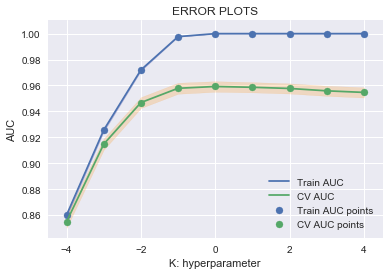

best c using L1 : 1
Wall time: 20min 5s


In [93]:
%%time
#hyperparameter tuning for L1 regularization
best_c_l1 = logit1(X_train_bow,y_train)
print('best c using L1 :',best_c_l1)

### Training model with best hyperparameter on L1 regularization

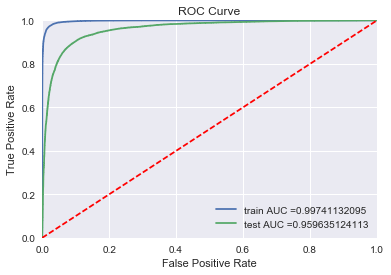

In [102]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
logol1 = LogisticRegression(C= best_c_l1, penalty= 'l1',class_weight = 'balanced')
logol1.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, logol1.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, logol1.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.951975986673 for threshold 0.855
Train Data


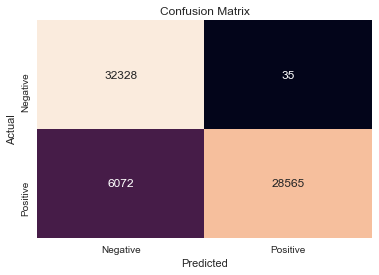

Test Data


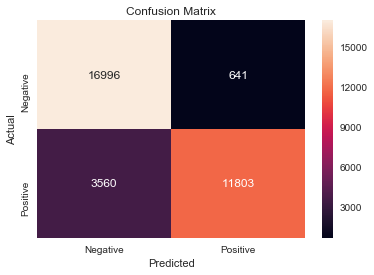

In [103]:
best_t_1 = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t_1,logol1)

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [104]:
w1 = logol1.coef_
total_feature = len(w1.T)
zero_feature =total_feature -  np.count_nonzero(w1)
print('Total zero features ',zero_feature)
print('Total non-zero features ',np.count_nonzero(w1))
total_percent = ((zero_feature/total_feature) * 100)
print('Sparsity on weight vector obtained using L1 regularization is %d percentage ' % (total_percent))

Total zero features  1196386
Total non-zero features  9308
Sparsity on weight vector obtained using L1 regularization is 99 percentage 


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

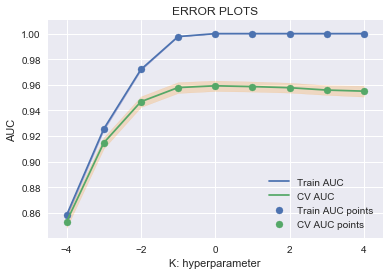

best c using L2 : 1
Wall time: 18min 2s


In [130]:
%%time
#hyperparameter tuning for L2 regularization
best_c_l2 = logit2(X_train_bow,y_train)
print('best c using L2 :',best_c_l2)

### Training model with best hyperparameter on L2 regularization

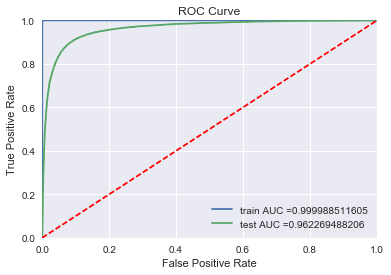

In [131]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
logol2 = LogisticRegression(C= best_c_l2, penalty= 'l2',class_weight = 'balanced')
logol2.fit(X_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, logol2.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, logol2.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.622718380948 for threshold 0.39
Train Data


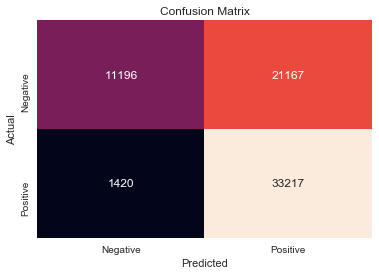

Test Data


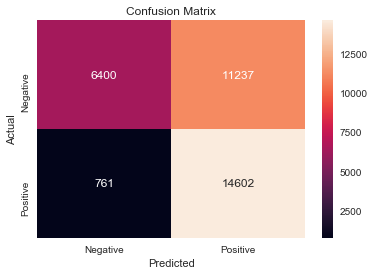

In [106]:
best_t_2 = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_bow,y_train,X_test_bow,y_test,best_t_2,logol2)

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [107]:
#Weights before adding noise
weights_original=logol2.coef_
print(weights_original.shape)

(1, 1205694)


In [109]:
import copy
Noise_bow=copy.deepcopy(X_train_scale)
e=np.random.normal(0,0.001)
Noise_bow.data += e
print(Noise_bow.shape)

(67000, 1205694)


In [111]:
#Calculating weights after adding noise
new_model = LogisticRegression(C= 0.1, penalty= 'l2',class_weight = 'balanced')
new_model.fit(Noise_bow,y_train)
weights_new=new_model.coef_
print(weights_new.shape)

(1, 1205694)


In [112]:
#Adding small noise to avoid zero divide error
small_noise=10**-6
weights_new+=small_noise
weights_original+=small_noise

In [113]:
#delta is diference between weights of original model and new model with noise
delta = np.abs((weights_original-weights_new)/weights_original)*100
print(delta)

[[  2173.48772901   1782.80864546  10282.99183135 ...,   3747.42737718
    3751.70820625   3751.70820625]]


In [114]:
#converting deltas to unorderd list
import itertools
pp = delta.T
list1 = pp.tolist()
unsorted = list(itertools.chain(*list1))
#sorting list in descending order
sorted_list = (sorted(unsorted,reverse=True))

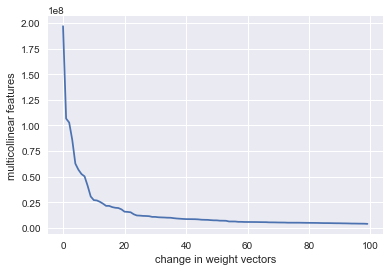

In [115]:
import matplotlib.pyplot as plt
plt.plot(sorted_list[:100])
plt.xlabel('change in weight vectors')
plt.ylabel('multicollinear features')
plt.show()

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [120]:
fn_bow = vectorizer.get_feature_names()
coefs_fn_bow = sorted(zip(logol2.coef_[0], fn_bow))
pos = pd.DataFrame(coefs_fn_bow[:-10:-1])
print('Top 10 important features of positive class: \n' ,pos)

Top 10 important features of positive class: 
           0          1
0  0.257945      great
1  0.152017       love
2  0.138271       best
3  0.136001       good
4  0.100817  delicious
5  0.087507       find
6  0.079913    perfect
7  0.075865        use
8  0.073148     little


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [121]:
neg = pd.DataFrame(coefs_fn_bow[:10])
print('Top 10 important features of negative class: \n' ,neg)

Top 10 important features of negative class: 
           0             1
0 -0.237430           not
1 -0.093803       product
2 -0.092164         would
3 -0.086382           bad
4 -0.084764  disappointed
5 -0.080163         money
6 -0.066766         taste
7 -0.064036       thought
8 -0.053759           box
9 -0.053046        bought


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

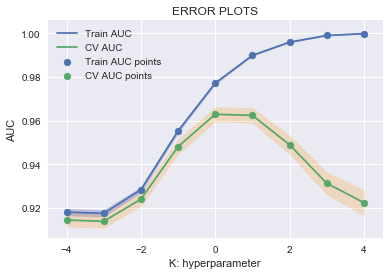

best c using L1 : 1
Wall time: 2min 28s


In [62]:
%%time
#hyperparameter tuning for L1 regularization
best_c_l1_tfidf = logit1(X_train_tfidf,y_train)
print('best c using L1 :',best_c_l1_tfidf)

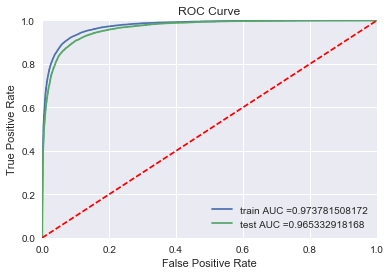

In [63]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
logol1_tfidf = LogisticRegression(C= best_c_l1_tfidf, penalty= 'l1',class_weight = 'balanced')
logol1_tfidf.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, logol1_tfidf.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, logol1_tfidf.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.84316659357 for threshold 0.176
Train Data


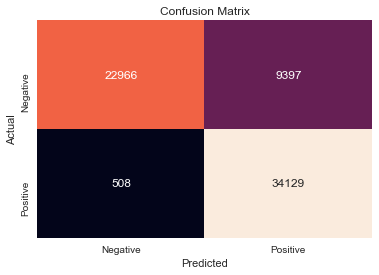

Test Data


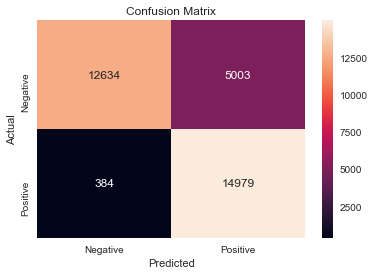

In [64]:
best_t_1_tfidf = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_tfidf,y_train,X_test_tfidf,y_test,best_t_1_tfidf,logol1_tfidf)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

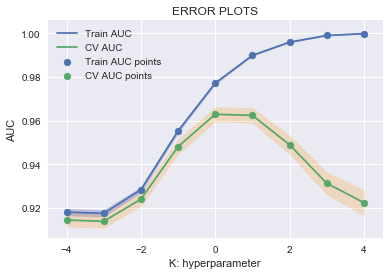

best c using L2 : 1
Wall time: 2min 28s


In [65]:
%%time
#hyperparameter tuning for L2 regularization
best_c_l2_tfidf = logit2(X_train_tfidf,y_train)
print('best c using L2 :',best_c_l2_tfidf)

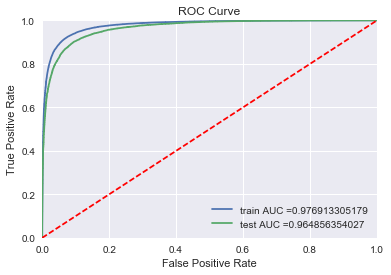

In [66]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
logol2_tfidf = LogisticRegression(C= best_c_l2_tfidf, penalty= 'l2',class_weight = 'balanced')
logol2_tfidf.fit(X_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, logol2_tfidf.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, logol2_tfidf.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.854360210644 for threshold 0.263
Train Data


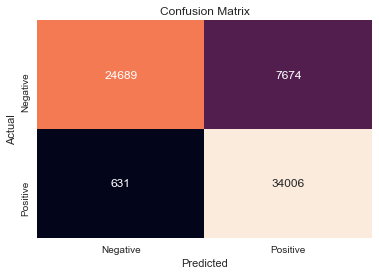

Test Data


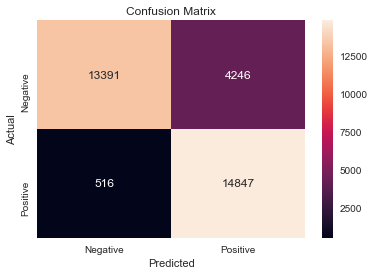

In [67]:
best_t_2_tfidf = find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(X_train_tfidf,y_train,X_test_tfidf,y_test,best_t_2_tfidf,logol2_tfidf)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [68]:
fn_tfidf = tf_idf_vect.get_feature_names()
coefs_fn_tfidf = sorted(zip(logol2_tfidf.coef_[0], fn_tfidf))
pos = pd.DataFrame(coefs_fn_tfidf[:-10:-1])
print('Top 10 important features of positive class: \n' ,pos)

Top 10 important features of positive class: 
            0                 1
0  10.573717             great
1   8.854412         delicious
2   8.549266              best
3   7.729901           perfect
4   7.344739              good
5   6.629780         excellent
6   6.329739  not disappointed
7   6.289994             loves
8   6.059119              love


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [69]:
neg = pd.DataFrame(coefs_fn_tfidf[:10])
print('Top 10 important features of negative class: \n' ,neg)

Top 10 important features of negative class: 
           0               1
0 -8.744880    disappointed
1 -7.637985             not
2 -7.303309       not worth
3 -7.269778           worst
4 -7.107374        not good
5 -6.995159   disappointing
6 -6.643521           awful
7 -6.562506        terrible
8 -6.186969   not recommend
9 -5.739473  disappointment


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

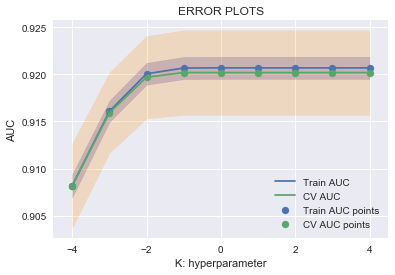

best c using L1 : 0.1
Wall time: 36.2 s


In [70]:
%%time
#hyperparameter tuning for L1 regularization
best_c_l1_avgw2v = logit1(sent_vectors_train,y_train)
print('best c using L1 :',best_c_l1_avgw2v)

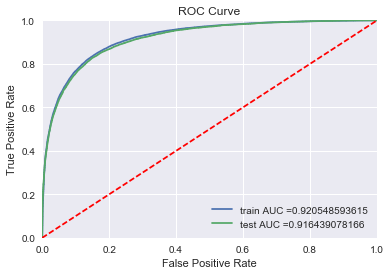

In [122]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
logol1_avgw2v = LogisticRegression(C= best_c_l1_avgw2v, penalty= 'l1',class_weight = 'balanced')
logol1_avgw2v.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, logol1_avgw2v.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, logol1_avgw2v.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.710458417124 for threshold 0.083
Train Data


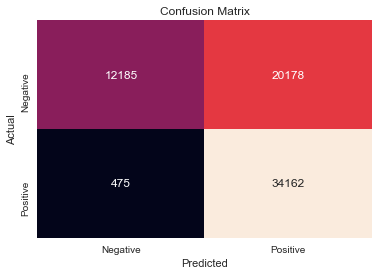

Test Data


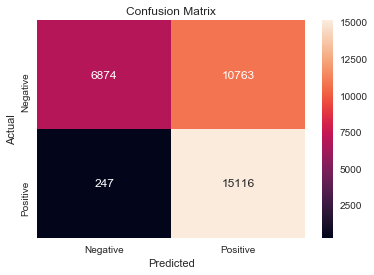

In [123]:
best_t_1_avgw2v= find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(sent_vectors_train,y_train,sent_vectors_test,y_test,best_t_1_avgw2v,logol1_avgw2v)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

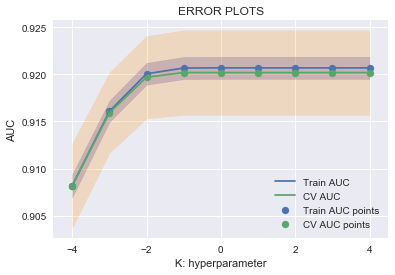

best c using L2 : 0.1
Wall time: 36.3 s


In [73]:
%%time
#hyperparameter tuning for L1 regularization
best_c_l2_avgw2v = logit2(sent_vectors_train,y_train)
print('best c using L2 :',best_c_l2_avgw2v)

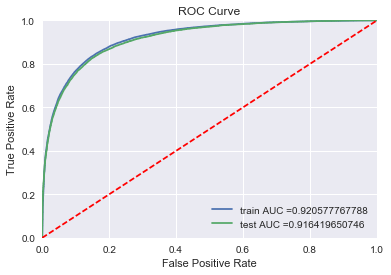

In [124]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
logol2_avgw2v = LogisticRegression(C= best_c_l2_avgw2v, penalty= 'l2',class_weight = 'balanced')
logol2_avgw2v.fit(sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, logol2_avgw2v.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, logol2_avgw2v.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

Train Data


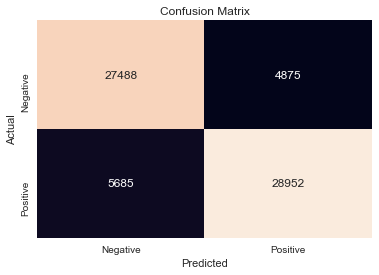

Test Data


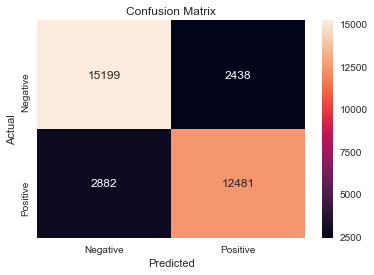

In [125]:
conf_matrix(sent_vectors_train,y_train,sent_vectors_test,y_test,0.5,logol2_avgw2v)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

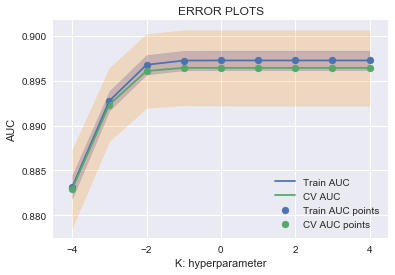

best c using L1 : 0.1
Wall time: 39.6 s


In [76]:
%%time
#hyperparameter tuning for L1 regularization
best_c_l1_tfidfw2v = logit1(tfidf_sent_vectors_train,y_train)
print('best c using L1 :',best_c_l1_tfidfw2v)

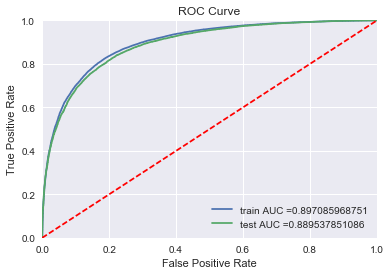

In [126]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
logol1_tfidfw2v = LogisticRegression(C= best_c_l1_tfidfw2v, penalty= 'l1',class_weight = 'balanced')
logol1_tfidfw2v.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, logol1_tfidfw2v.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, logol1_tfidfw2v.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.67075817989 for threshold 0.076
Train Data


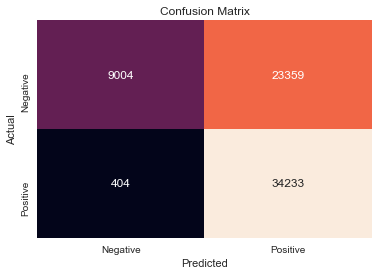

Test Data


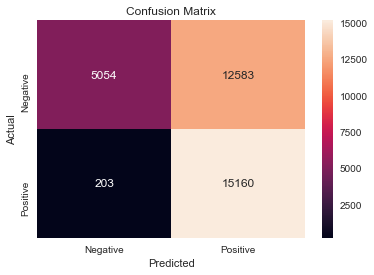

In [127]:
best_t_1_tfidfw2v= find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(tfidf_sent_vectors_train,y_train,tfidf_sent_vectors_test,y_test,best_t_1_tfidfw2v,logol1_tfidfw2v)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

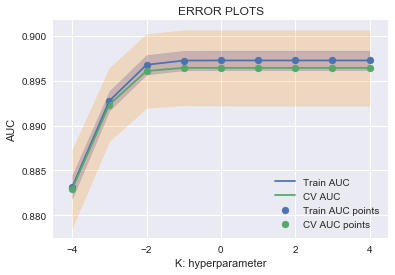

best c using L1 : 0.1
Wall time: 39.6 s


In [79]:
%%time
#hyperparameter tuning for L2 regularization
best_c_l2_tfidfw2v = logit2(tfidf_sent_vectors_train,y_train)
print('best c using L1 :',best_c_l2_tfidfw2v)

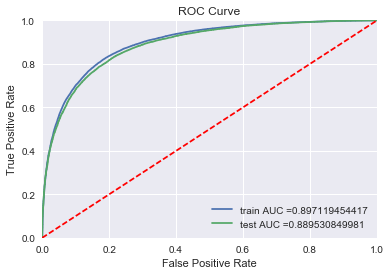

In [128]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
logol2_tfidfw2v = LogisticRegression(C= best_c_l2_tfidfw2v, penalty= 'l2',class_weight = 'balanced')
logol2_tfidfw2v.fit(tfidf_sent_vectors_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs
train_fpr, train_tpr, thresholds = roc_curve(y_train, logol2_tfidfw2v.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, logol2_tfidfw2v.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.grid(True)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

the maximum value of tpr*(1-fpr) 0.670600286266 for threshold 0.069
Train Data


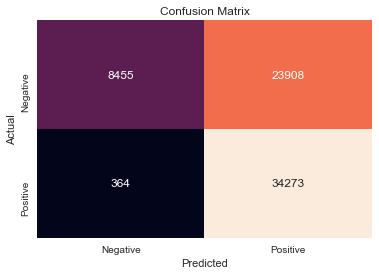

Test Data


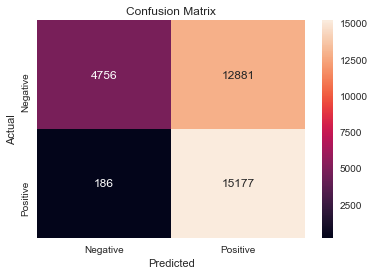

In [129]:
best_t_2_tfidfw2v= find_best_threshold(thresholds, train_fpr, train_tpr)
conf_matrix(tfidf_sent_vectors_train,y_train,tfidf_sent_vectors_test,y_test,best_t_2_tfidfw2v,logol2_tfidfw2v)

# [6] Conclusions

In [133]:
# Creating table using PrettyTable library
from prettytable import PrettyTable
vectorizer = ['BOW','TFIDF','Avgw2v','TFIDFW2v','BOW','TFIDF','Avgw2v','TFIDFW2v' ]
AUC = [0.95,0.96,0.91,0.88,0.94,0.96,0.91,0.88]
Model = ['Logistic Regression (L1)','Logistic Regression (L1)','Logistic Regression (L1)','Logistic Regression (L1)','Logistic Regression (L2)','Logistic Regression (L2)','Logistic Regression (L2)','Logistic Regression (L2)',]
hyperparameter= [1,1,0.1,0.1,1,1,0.1,0.1]
sno = [1,2,3,4,5,6,7,8]
# Initializing prettytable
ptable = PrettyTable()
# Adding columns
ptable.add_column("S.NO.",sno)
ptable.add_column("     Vectorizer            ",vectorizer)
ptable.add_column("      Model                         "   ,      Model)
ptable.add_column("  Best C     ",hyperparameter)
ptable.add_column("  Test AUC              ",AUC)
# Printing the Table
print(ptable)

+-------+-----------------------------+--------------------------------------+---------------+--------------------------+
| S.NO. |      Vectorizer             |       Model                          |   Best C      |   Test AUC               |
+-------+-----------------------------+--------------------------------------+---------------+--------------------------+
|   1   |             BOW             |       Logistic Regression (L1)       |       1       |           0.95           |
|   2   |            TFIDF            |       Logistic Regression (L1)       |       1       |           0.96           |
|   3   |            Avgw2v           |       Logistic Regression (L1)       |      0.1      |           0.91           |
|   4   |           TFIDFW2v          |       Logistic Regression (L1)       |      0.1      |           0.88           |
|   5   |             BOW             |       Logistic Regression (L2)       |       1       |           0.94           |
|   6   |            TFI

In [134]:
!jupyter nbconvert --to html AFFRLGR.ipynb

[NbConvertApp] Converting notebook AFFRLGR.ipynb to html
[NbConvertApp] Writing 1269290 bytes to AFFRLGR.html
